In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
%matplotlib inline
ox.config(log_console=True)
weight_by_length = False
plt.style.context('seaborn-bright')
ox.__version__
import geopandas as gpd
import seaborn as sns

In [3]:
milan_df = gpd.read_file('scratchpad/shapefile.shp')

In [4]:
milan_df

,latitude,longitude,placename,lat_min,lat_max,lon_min,lon_max,geometry
0,45.44195,9.15325,197.0,45.4396,45.4443,9.1509,9.1556,"POLYGON ((9.15090 45.44430, 9.15560 45.44430, ..."
1,45.44195,9.15795,198.0,45.4396,45.4443,9.1556,9.1603,"POLYGON ((9.15560 45.44430, 9.16030 45.44430, ..."
2,45.44195,9.16735,200.0,45.4396,45.4443,9.1650,9.1697,"POLYGON ((9.16500 45.44430, 9.16970 45.44430, ..."
3,45.44195,9.17205,201.0,45.4396,45.4443,9.1697,9.1744,"POLYGON ((9.16970 45.44430, 9.17440 45.44430, ..."
4,45.44195,9.17675,202.0,45.4396,45.4443,9.1744,9.1791,"POLYGON ((9.17440 45.44430, 9.17910 45.44430, ..."
...,...,...,...,...,...,...,...,...
219,45.50305,9.18615,685.0,45.5007,45.5054,9.1838,9.1885,"POLYGON ((9.18380 45.50540, 9.18850 45.50540, ..."
220,45.50305,9.19085,686.0,45.5007,45.5054,9.1885,9.1932,"POLYGON ((9.18850 45.50540, 9.19320 45.50540, ..."
221,45.50305,9.19555,687.0,45.5007,45.5054,9.1932,9.1979,"POLYGON ((9.19320 45.50540, 9.19790 45.50540, ..."
222,45.50305,9.20025,688.0,45.5007,45.5054,9.1979,9.2026,"POLYGON ((9.19790 45.50540, 9.20260 45.50540, ..."


In [5]:

G = ox.graph_from_polygon(milan_df.iloc[1]['geometry'], network_type='all')

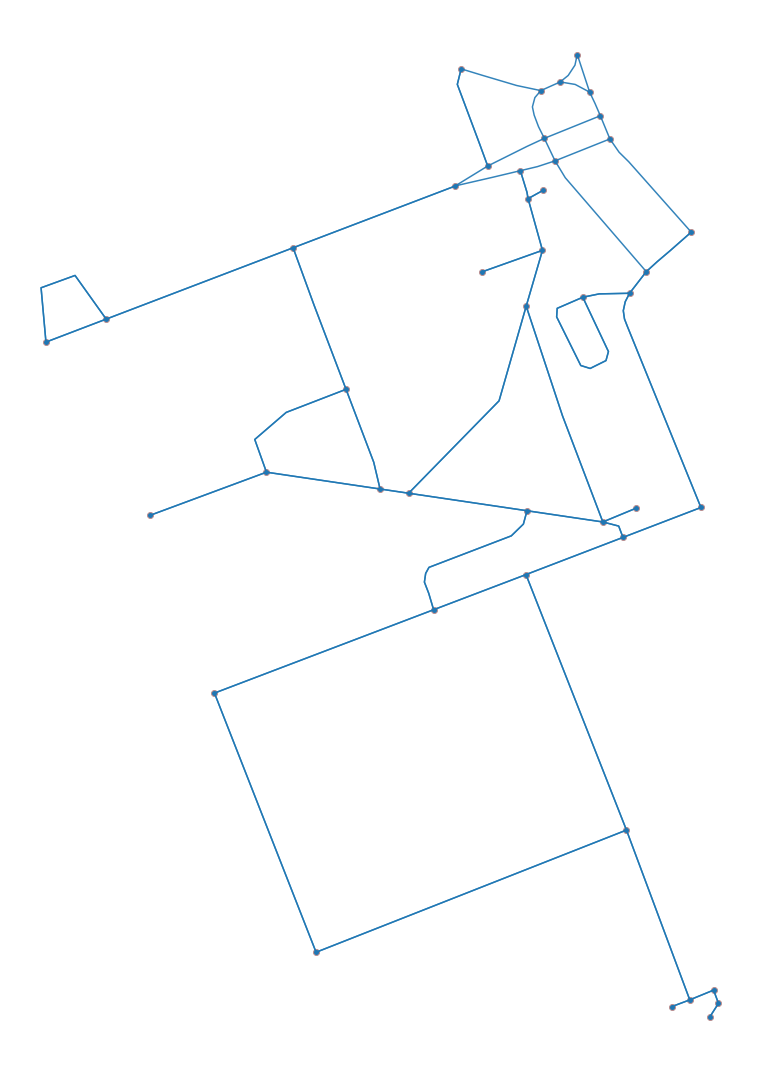

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
ax.axis('off')
nodes, edges = ox.graph_to_gdfs(G)
# area.plot(ax=ax)
nodes.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
edges.plot(ax=ax, alpha=0.9)
plt.tight_layout()

In [ ]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

from tqdm import tqdm
bearings = {}
for index,row in tqdm(milan_df.iterrows()):
    place = row['placename']
    G = ox.graph_from_polygon(row['geometry'], network_type='all')
#     # calculate edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    weight_by_length = True
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

172it [03:21,  1.50s/it]

In [11]:
%store bearings

Stored 'bearings' (dict)


In [13]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]


# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    hist , division = np.histogram(bearings, bins=bins , density = True) 
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'DejaVu Sans', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'DejaVu Sans', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'DejaVu Sans', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)
    return frequency

In [14]:
def computeFreq(bearings, n=36):
    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    hist , division = np.histogram(bearings, bins=bins , density = True) 
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n
    return frequency

In [15]:
bearings.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [17]:
# # create figure and axes
normed_freq = {}
# plot each city's polar histogram
for place in sorted(bearings.keys()):
    normed_freq[place] = computeFreq(bearings[place].dropna())

In [19]:
EntropyDict = {'placename':[] , 'street_entropy':[]}
for place in normed_freq:
    EntropyDict['placename'].append(place)
    entropy = -sum([float(p)*np.log(float(p)) for p in normed_freq[place] if p >0.])
    EntropyDict['street_entropy'].append(entropy)

df = pd.DataFrame.from_dict(EntropyDict)

/work/sagarj/miniconda3/envs/opencv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='street_entropy', ylabel='Density'>

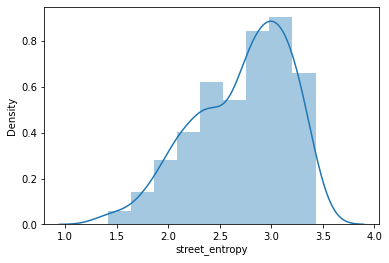

In [23]:
sns.distplot(df['street_entropy'])

In [25]:
df.to_csv('scratchpad/milan_FID_streetentropy.csv')